# SIR dynamics: fit the scales to a simplified function, using different infectivity matrices

[Index](0-index.ipynb)

We fit the scale parameter every day so as to minimize the sum of square errors with local reports of infection using:
* the SafeGraph derived infectivity matrix;
* a uniform infectivity matrix;
* the SafeGraph derived infectivity matrix truncated to close geographical distances.

The scale parameter is constrained to a functional shape $p(t) = c\ln{\left(1 + e^{-a (t-b)} \right)} + d$. The fitting is performed with the script [6-LSQ_fit_scales_simplified_exec](6-LSQ_fit_scales_simplified_exec.py), which uses the results of the script [5-LSQ_fit_scales_exec](5-LSQ_fit_scales_exec.py). The analysis is performed in this notebook.



## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import os,sys
import numpy as np
import pandas as pd
import datetime
import scipy
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar, bracket, curve_fit, Bounds
import scipy.stats as sst

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append(str(Path('..') / 'code'))

In [4]:
from functions import func_sir_dX, sir_SI_to_X, sir_X_to_SI, func_sir_dV, guess_scale, fsigmoid, fsigmoid_jac, framp2, framp2_jac, get_dTs, plot_scatter, plot_omega_profile, plot_omega_map

In [5]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [6]:
resfile = resdir / 'safegraph_analysis.hdf5'
complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

File safegraph_analysis has 2188 entries.


In [7]:
figdir = Path('../figures') / '6-LSQ_fit_scales_simplified'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

In [8]:
colors = ['darkblue', 'darkgreen', 'magenta']
labels = ["safegraph", "uniform", "distance_trunc"]
dpi=300

## Global variables and other quantities

### Global variables

In [9]:
gamma = 1/10.
ti = '2020-03-01'
# tf = '2020-09-01'
tf = '2021-02-16'

tfmt = '%Y-%m-%d'
ti = datetime.datetime.strptime(ti, tfmt)
tf = datetime.datetime.strptime(tf, tfmt)

exts = ['.png', '.svg']

### Load clusters to get population

In [10]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
# clusters = pd.read_hdf(resfile, key)
N = len(clusters)
print(f"N = {N}")
clusters

N = 1024


leaves           X          Y  \
index                                  
0         746  -65.794825  18.277415   
1         458  -66.083320  18.131576   
2         873  -66.079340  18.396328   
3           8  -66.344566  18.363775   
4         641  -66.582628  18.044742   
...       ...         ...        ...   
1019      911 -158.026269  21.423245   
1020        7 -157.813184  21.329035   
1021      392 -156.517054  20.867763   
1022      808 -155.865732  19.692965   
1023      134 -155.089968  19.680449   

                                            cbg_clusters  population  \
index                                                                  
0      [720531504003, 720531501044, 720531505001, 720...      390728   
1      [720572702011, 720572703004, 720572705001, 720...      488287   
2      [720210307001, 720210310113, 720210316223, 720...     1011530   
3      [720399559001, 720399556001, 720399557001, 720...      425126   
4      [721130724005, 721130727011, 721130727012, 721...      354598   
...                                                  ...         ...   
1019   [150030078092, 150030078102, 150030099044, 150...      459209   
1020   [150090318011, 150099900000, 150030047001, 150...      529047   
1021   [150090311032, 150090304042, 150090309034, 150...      161290   
1022   [150010216012, 150010214023, 150010216041, 150...       88670   
1023   [150010210053, 150010210052, 150019904000, 150...      105010   

       mobile_count  
index                
0       8705.198547  
1      10942.351090  
2      28389.915254  
3       9988.154964  
4      12057.116223  
...             ...  
1019   22780.496368  
1020   21868.060533  
1021    7878.004843  
1022    3758.949153  
1023    4298.900726  

[1024 rows x 6 columns]

In [11]:
population = clusters['population'].to_numpy()
population_inv = np.zeros(population.shape, dtype=np.float_)
idx = population > 0.
population_inv[idx] = 1./population[idx]

### Load CSSEGI data

In [12]:
path = '/clustering/cssegi'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    df_cssegi = store[path]

times = df_cssegi.index
idx = (times >= ti) & (times <= tf)
df_cssegi.drop(index=times[~idx], inplace=True)
times = df_cssegi.index.to_pydatetime().tolist()
df_cssegi

index       0     1     2     3     4     5     6     7     8     9     ...  \
2020-03-01     0     0     0     0     0     0     0     0     0     0  ...   
2020-03-02     0     0     0     0     0     0     0     0     0     0  ...   
2020-03-03     0     0     0     0     0     0     0     0     0     0  ...   
2020-03-04     0     0     0     0     0     0     0     0     0     0  ...   
2020-03-05     0     0     0     0     0     0     0     0     0     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2021-02-12     0     0     0     0     0     0     0     0  1215   239  ...   
2021-02-13     0     0     0     0     0     0     0     0  1221   241  ...   
2021-02-14     0     0     0     0     0     0     0     0  1227   241  ...   
2021-02-15     0     0     0     0     0     0     0     0  1231   241  ...   
2021-02-16     0     0     0     0     0     0     0     0  1236   242  ...   

index       1014  1015  1016  1017  1018   1019  1020  1021  1022  1023  
2020-03-01     0     0     0     0     0      0     0     0     0     0  
2020-03-02     0     0     0     0     0      0     0     0     0     0  
2020-03-03     0     0     0     0     0      0     0     0     0     0  
2020-03-04     0     0     0     0     0      0     0     0     0     0  
2020-03-05     0     0     0     0     0      0     0     0     0     0  
...          ...   ...   ...   ...   ...    ...   ...   ...   ...   ...  
2021-02-12     0     0   397     0   181  21712     0  2540  2239     0  
2021-02-13     0     0   397     0   181  21758     0  2549  2241     0  
2021-02-14     0     0   397     0   181  21794     0  2553  2244     0  
2021-02-15     0     0   397     0   181  21817     0  2561  2244     0  
2021-02-16     0     0   464     0   181  21830     0  2564  2244     0  

[353 rows x 1024 columns]

In [13]:
omega_real = df_cssegi.to_numpy().astype('float64')
domega_real = np.diff(omega_real, axis=0)
domega_real = np.concatenate([omega_real[0].reshape(1,-1), domega_real], axis=0)

In [14]:
# compute the real epidemic sizes per community through time
Ts_real = np.einsum('ta,a->ta', omega_real, population_inv)
Ss_real = 1. - Ts_real
dTs_real = np.einsum('ta,a->ta', domega_real, population_inv)
T_tot_real = np.einsum('ta,a->t', Ts_real, population) / np.sum(population)
S_tot_real = np.einsum('ta,a->t', Ss_real, population) / np.sum(population)
dT_tot_real = np.einsum('ta,a->t', dTs_real, population) / np.sum(population)
Ss_real[~(Ss_real > 0.)] = np.finfo(np.float64).resolution

Show the total epidemic size from real data

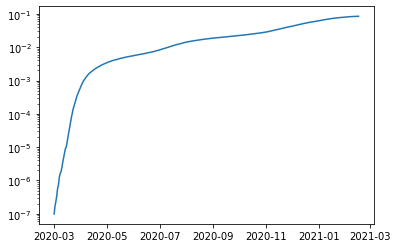

In [15]:
plt.plot(times, T_tot_real)
plt.gca().set_yscale('log')

Show the initial condition

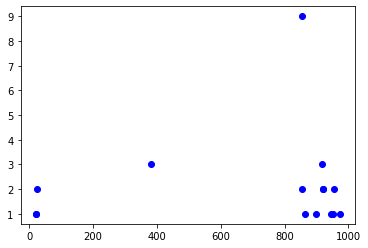

In [16]:
X = clusters.index.to_numpy()
Y = np.einsum('ta,a->ta', 1.-Ss_real, population)[0]
idx = Y > 0
plt.plot(X[idx],Y[idx], 'bo')

Define the V-vector

In [17]:
Vs_real = -np.log(Ss_real/Ss_real[0])

## Integrate the dynamics based on the (S,I) variables

### SG matrix

In [18]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'scales' / 'sifit_safegraph' / 'infectivity_matrices'
    mykey = str(path / times[0].strftime(tfmt))
    L_sg = store[mykey].to_numpy().astype('float64')
    
    path = Path('/fit') / 'scales' / 'sifit_safegraph' / 'result'
    mykey = str(path / 'susceptible')
    Ss_sifit_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'infected')
    Is_sifit_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_sifit_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_sifit_sg = store[mykey].to_numpy().astype('float64').ravel()

In [19]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:    
    path = Path('/fit') / 'scales' / 'siramp_safegraph' / 'result'
    mykey = str(path / 'susceptible')
    Ss_siramp_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'infected')
    Is_siramp_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_siramp_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_siramp_sg = store[mykey].to_numpy().astype('float64')

dTs_siramp_sg, dT_tot_siramp_sg = get_dTs(Ss_siramp_sg, population)

In [20]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_siramp_sg, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_siramp_sg'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_siramp_sg.png
Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_siramp_sg.svg


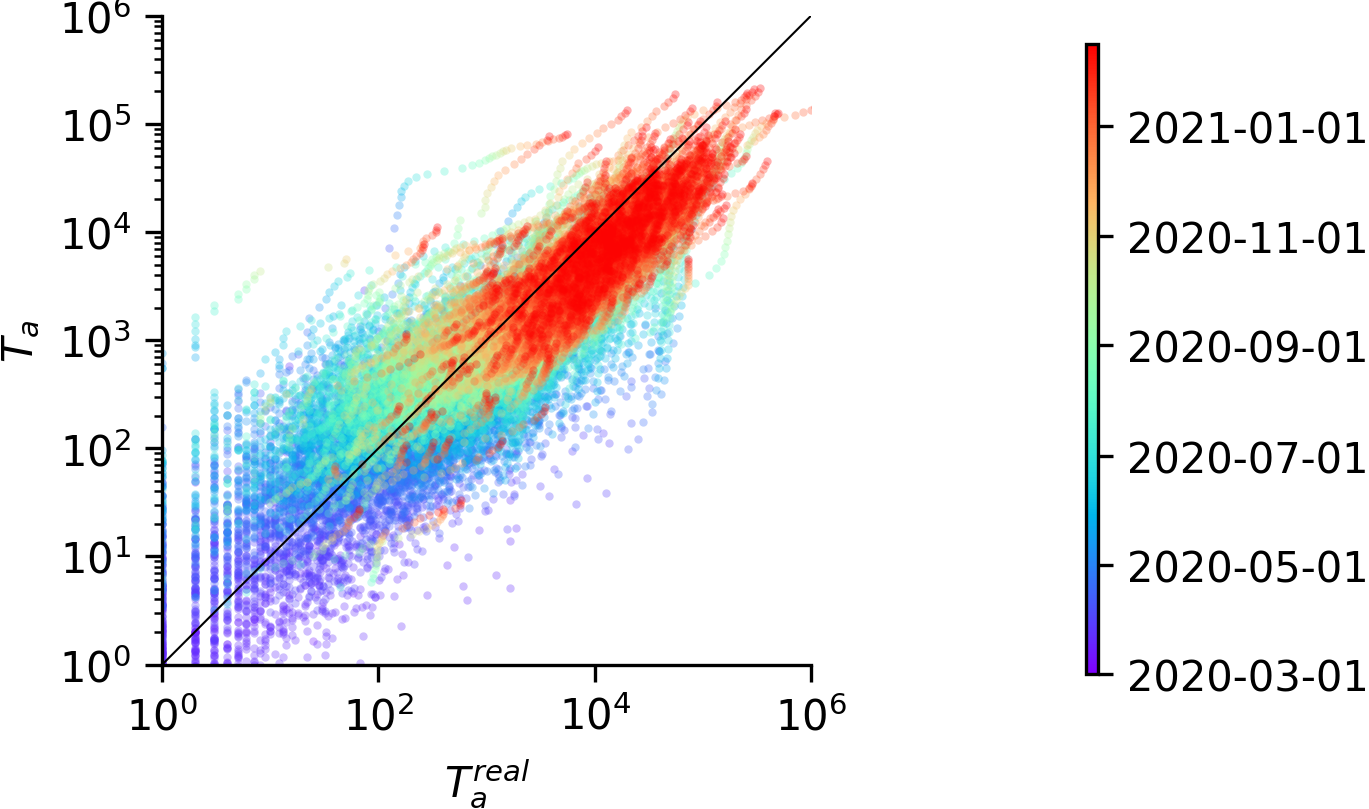

In [21]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [22]:
Xs = Vs_real
Ys = Vs_siramp_sg
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_siramp_sg'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_siramp_sg.png
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_siramp_sg.svg


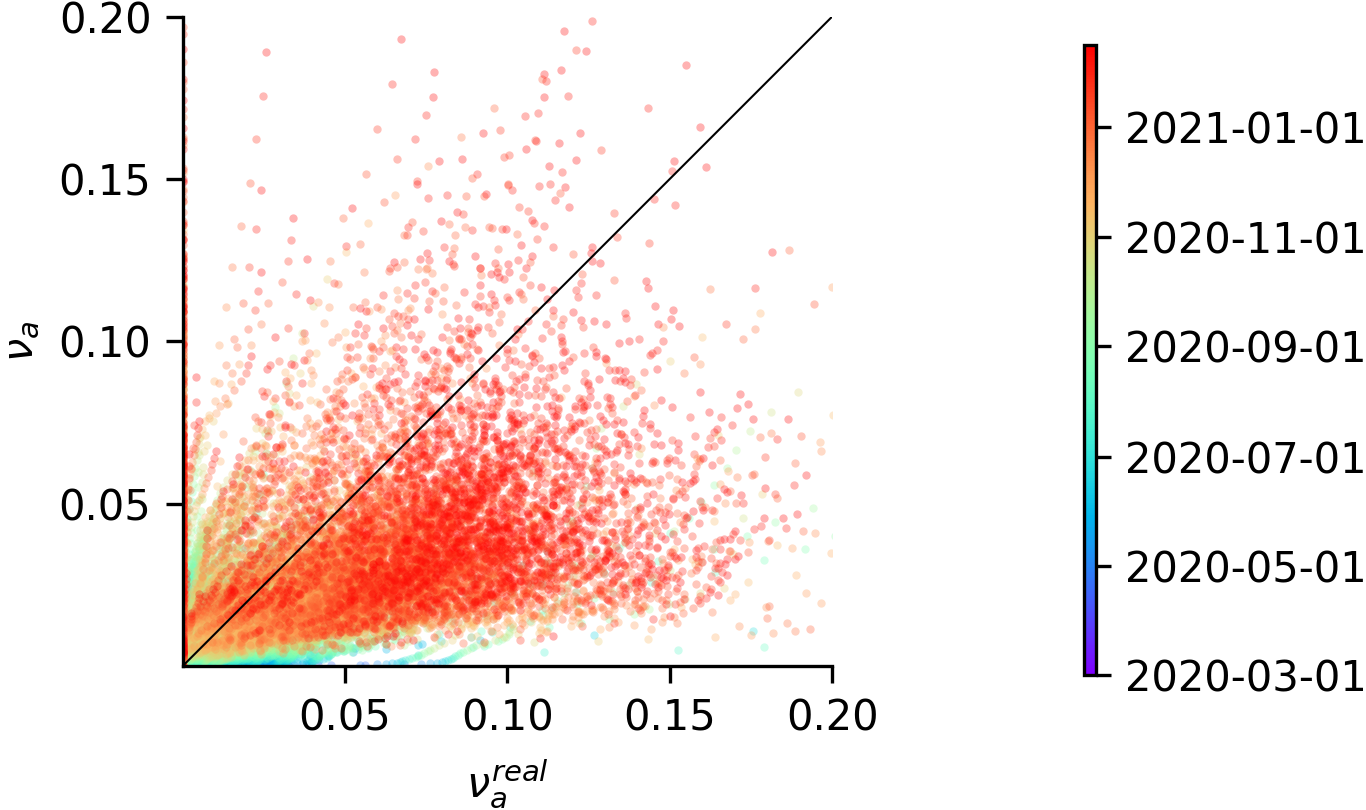

In [23]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Uniform matrix

In [24]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'scales' / 'sifit_uniform' / 'infectivity_matrices'
    mykey = str(path / times[0].strftime(tfmt))
    L_unif = store[mykey].to_numpy().astype('float64')
    
    path = Path('/fit') / 'scales' / 'sifit_uniform' / 'result'
    mykey = str(path / 'susceptible')
    Ss_sifit_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'infected')
    Is_sifit_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_sifit_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_sifit_unif = store[mykey].to_numpy().astype('float64').ravel()

In [25]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:    
    path = Path('/fit') / 'scales' / 'siramp_uniform' / 'result'
    mykey = str(path / 'susceptible')
    Ss_siramp_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'infected')
    Is_siramp_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_siramp_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_siramp_unif = store[mykey].to_numpy().astype('float64')

dTs_siramp_unif, dT_tot_siramp_unif = get_dTs(Ss_siramp_unif, population)

In [26]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_siramp_unif, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_siramp_unif'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_siramp_unif.png
Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_siramp_unif.svg


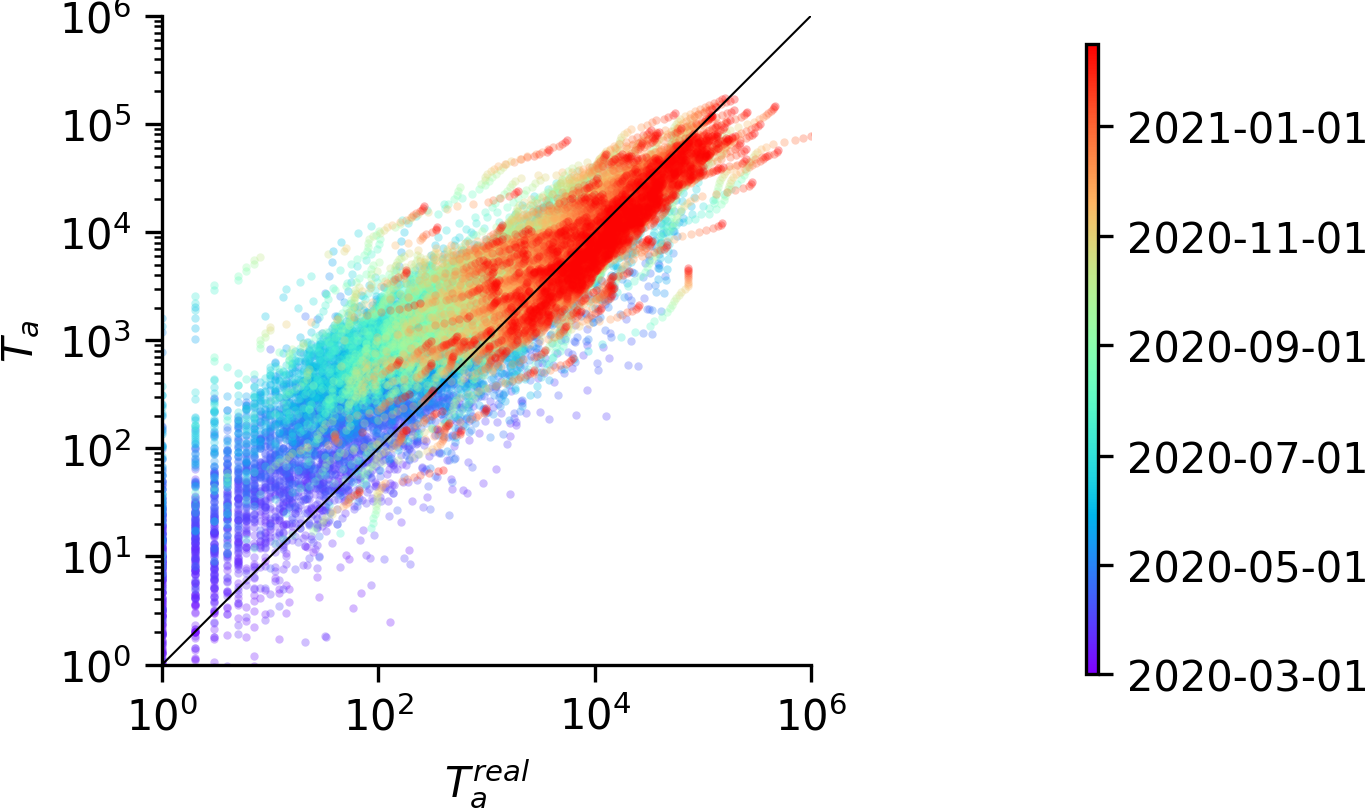

In [27]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [28]:
Xs = Vs_real
Ys = Vs_siramp_unif
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_siramp_unif'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_siramp_unif.png
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_siramp_unif.svg


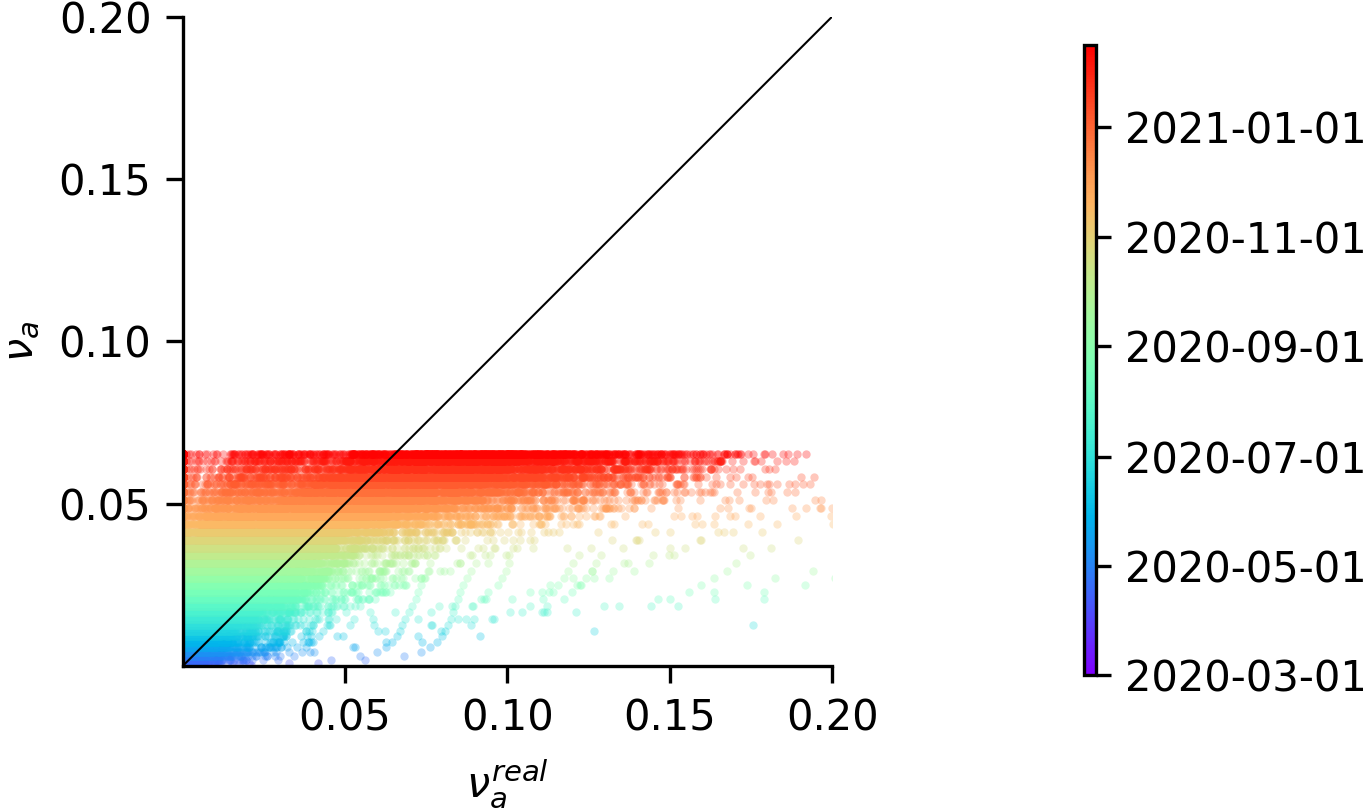

In [29]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Distance truncated matrix

In [30]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'scales' / 'sifit_distance_trunc_400km' / 'infectivity_matrices'
    mykey = str(path / times[0].strftime(tfmt))
    L_trunc = store[mykey].to_numpy().astype('float64')
    
    path = Path('/fit') / 'scales' / 'sifit_distance_trunc_400km' / 'result'
    mykey = str(path / 'susceptible')
    Ss_sifit_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'infected')
    Is_sifit_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_sifit_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_sifit_trunc = store[mykey].to_numpy().astype('float64').ravel()

In [31]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:    
    path = Path('/fit') / 'scales' / 'siramp_distance_trunc' / 'result'
    mykey = str(path / 'susceptible')
    Ss_siramp_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'infected')
    Is_siramp_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_siramp_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_siramp_trunc = store[mykey].to_numpy().astype('float64')

dTs_siramp_trunc, dT_tot_siramp_trunc = get_dTs(Ss_siramp_trunc, population)

In [32]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_siramp_trunc, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_siramp_trunc'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_siramp_trunc.png
Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_siramp_trunc.svg


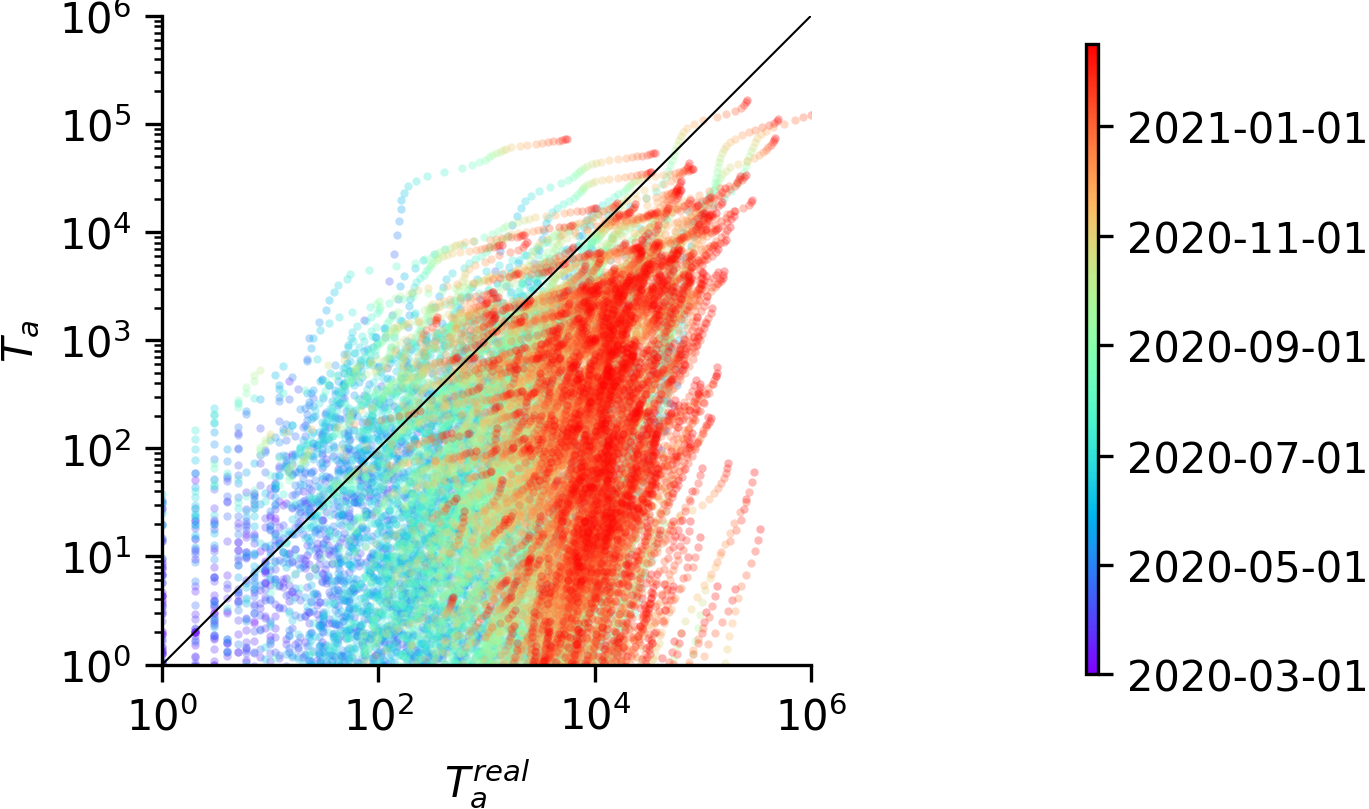

In [33]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [34]:
Xs = Vs_real
Ys = Vs_siramp_trunc
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_siramp_trunc'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_siramp_trunc.png
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_siramp_trunc.svg


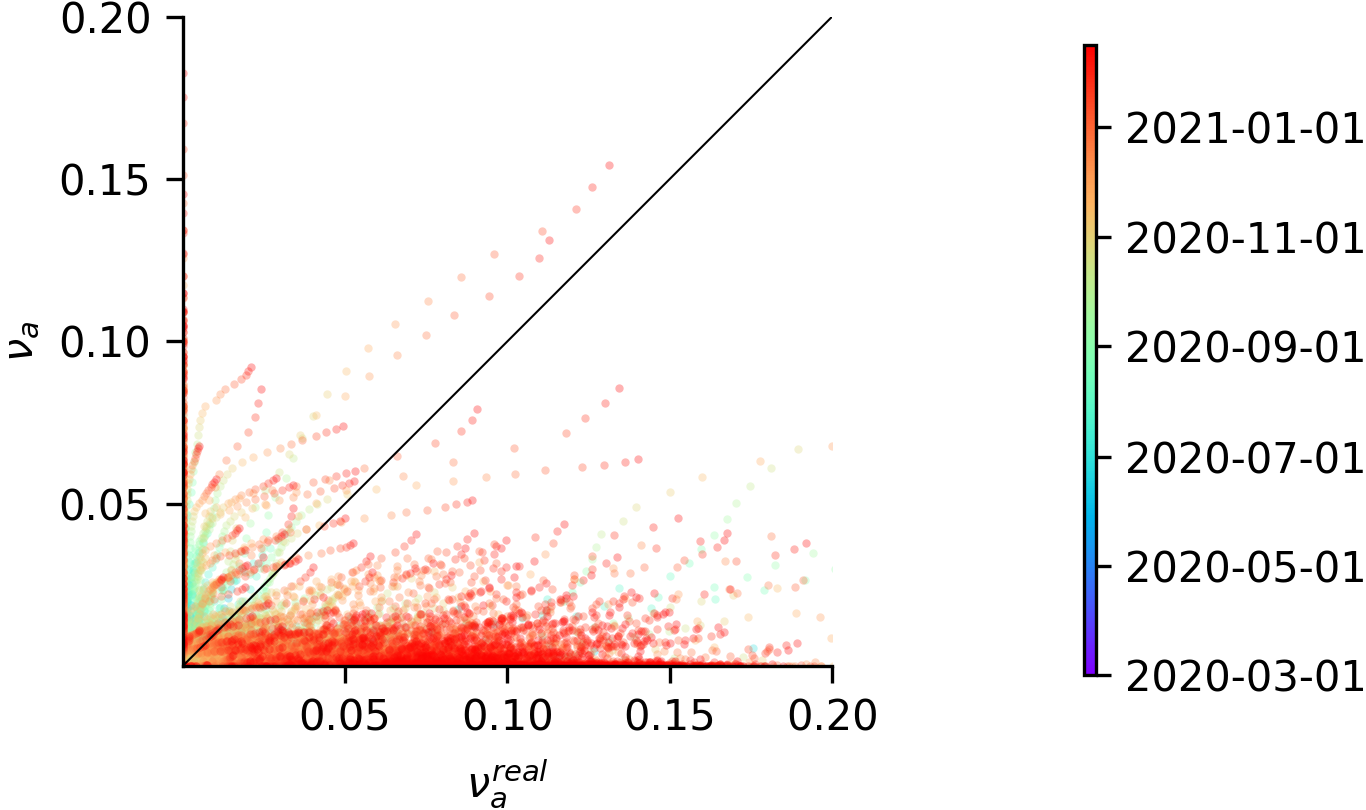

In [35]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Additional analysis and plots

In [36]:
Ss_fit_list = np.array([Ss_sifit_sg, Ss_sifit_unif, Ss_sifit_trunc])
Ss_ramp_list = np.array([Ss_siramp_sg, Ss_siramp_unif, Ss_siramp_trunc])
dTs_ramp_list = np.array([dTs_siramp_sg, dTs_siramp_unif, dTs_siramp_trunc])
T_tot_ramp_list = np.einsum('ita,a->it', 1.-Ss_ramp_list, population)
dT_tot_ramp_list = np.array([dT_tot_siramp_sg, dT_tot_siramp_unif, dT_tot_siramp_trunc])
scales_fit_list = np.array([scales_sifit_sg, scales_sifit_unif, scales_sifit_trunc])
scales_ramp_list = np.array([scales_siramp_sg, scales_siramp_unif, scales_siramp_trunc])

In [37]:
# parameters
figsize = (4,3)
dpi = 300
ms=3
lw=0.5

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

for i in range(len(scales_fit_list)):
    ax.plot(times[:-1], scales_fit_list[i]/np.mean(scales_ramp_list[i,-1]), 'o', color=colors[i], mfc='none', ms=ms, mew=lw, label=labels[i])
    ax.plot(times[:-1], scales_ramp_list[i]/np.mean(scales_ramp_list[i,-1]), '-', color=colors[i], lw=lw)

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.set_xlim(times[0],None)
ax.set_ylim(0,None)
# ax.set_xlabel("date", fontsize="medium")
ax.set_ylabel("$p \\beta$", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'scales_si'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')
# plt.show()

Written file: ../figures/6-LSQ_fit_scales_simplified/scales_si.png
Written file: ../figures/6-LSQ_fit_scales_simplified/scales_si.svg


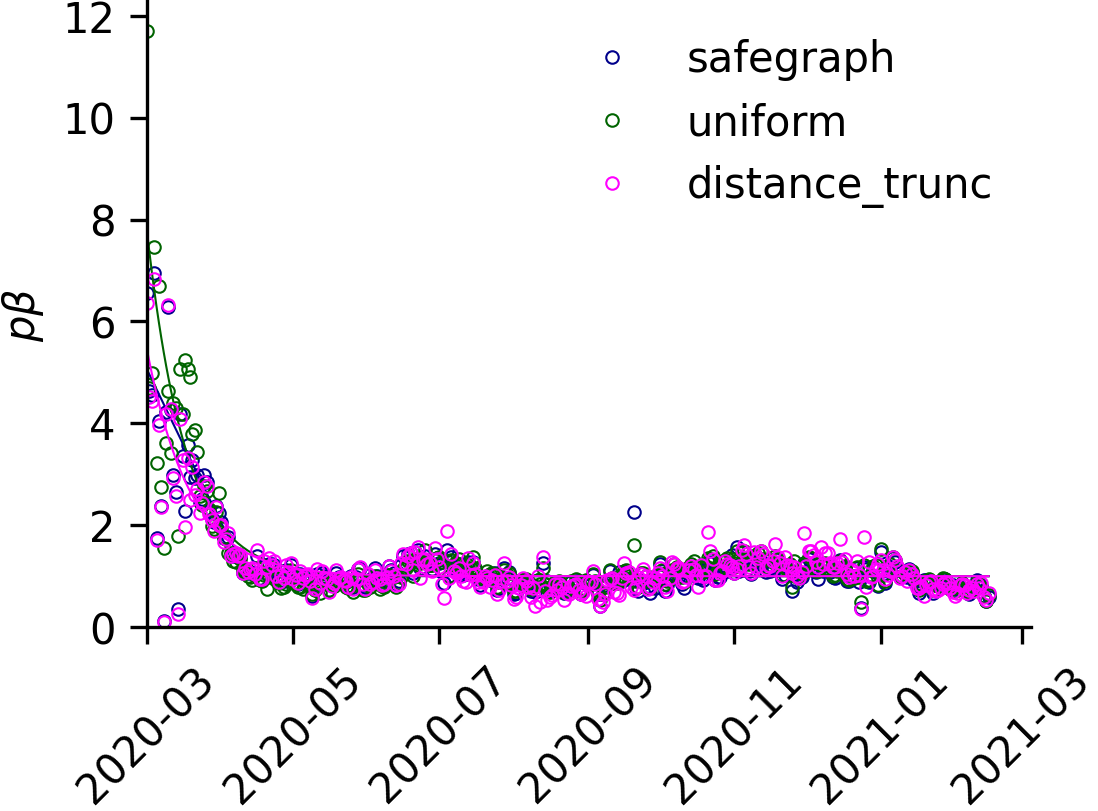

In [38]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [39]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=6
lw=1
show_dT=True
n0=None
ptot = np.sum(population) / 1.0e3

# U = np.einsum('ta,a->ta',(Ts_real-Ts), population)
# Z = np.sqrt(np.einsum('ta,ta->t', U, U) / N)
# print("{:.2e}".format(np.einsum('ta,ta', U, U) / N*len(times)))


fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

if show_dT:
    for i in range(len(dT_tot_ramp_list)):
        ax.plot(times[:n0],dT_tot_ramp_list[i, :n0]*ptot, '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])
    ax.plot(times[:n0],dT_tot_real[:n0]*ptot, 'o', ms=ms, color='red', mfc='none', mew=lw)
    ax.set_ylabel("$d T$ [x1e3]", fontsize="medium")
    fname = 'dT_tot_ramp_si'
else:
    for i in range(len(dT_tot_ramp_list)):
        ax.plot(times[:n0],T_tot_ramp_list[i, :n0]*ptot, '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])
    ax.plot(times[:n0],T_tot_real[:n0]*ptot, '-', lw=lw, color='red')
    ax.set_ylabel("$T$ [x1e3]", fontsize="medium")
    ax.set_yscale('log')
    fname = 'T_tot_ramp_si'


ax.legend(loc='best', fontsize='medium', frameon=False)
ax.set_xlim(times[0],None)
ax.set_ylim(0,None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/6-LSQ_fit_scales_simplified/dT_tot_ramp_si.png
Written file: ../figures/6-LSQ_fit_scales_simplified/dT_tot_ramp_si.svg


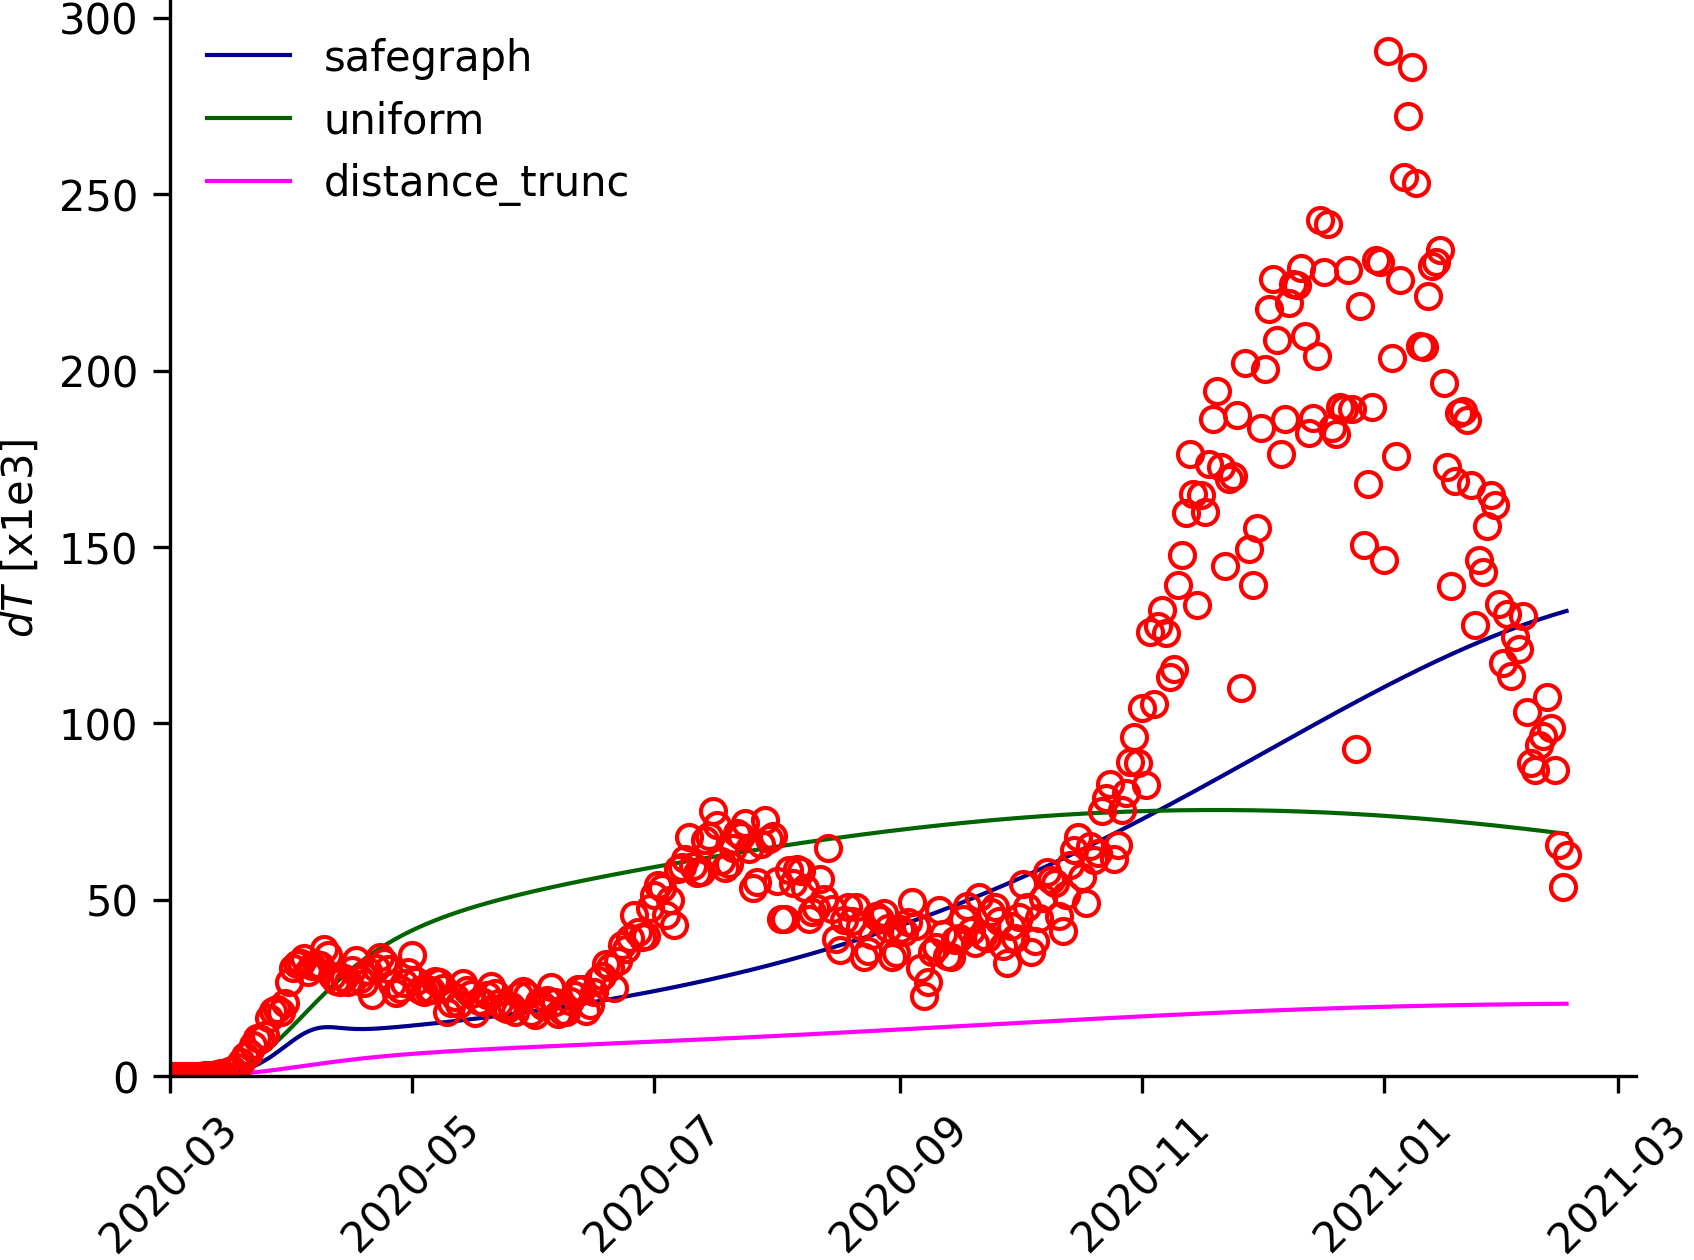

In [40]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [41]:
# parameters
figsize = (6,4.5)
dpi = 300
lw=1
ms=4
# bins='doane'
bins='auto'
# bins=2**8
a=10

data = np.array([(np.einsum('ta,a->ta', Ss - Ss_real, population)).ravel() for Ss in Ss_ramp_list])

q1,q2 = np.percentile(data, [a*0.5, 100-a*0.5])
print(q1, q2)
hist, edges = np.histogram(data[~((data < q1) | (data > q2))], bins=bins, density=True)
print("nbins = {}    bwidth = {}    a = {}    b = {}".format(len(edges)-1, edges[1]-edges[0], edges[0], edges[-1]))

hists = []
for dat in data:
    hist, edges = np.histogram(dat, bins=edges, density=True)
    hists.append(hist)

mus = np.mean(data, axis=1)
stds = np.std(data, axis=1)
iqrs = sst.iqr(data, axis=1)

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

X = 0.5*(edges[:-1] + edges[1:])

for i in range(len(data)):
    hist = hists[i]
    ax.plot(X, hist, 'o-', ms=ms, color=colors[i], label=labels[i])
    ax.annotate("mean = {:.1e}\nstd = {:.1e}\niqr = {:.1e}".format(mus[i], stds[i], iqrs[i]), xy=(0.02, 0.98-i*0.2), \
            xycoords="axes fraction", ha="left", va="top", fontsize="medium", color=colors[i])
    
ax.set_xlabel("T - T_real", fontsize="medium")
ax.set_ylabel("pdf", fontsize="medium")

ax.legend(loc='upper right', fontsize='large', frameon=False)
ax.set_ylim(0.,None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()
# plt.show()

fname = "T_errors_si"
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

-7111.262608392651 21597.243005862256
nbins = 575    bwidth = 49.92769775815759    a = -7111.25617048909    b = 21597.17004045131
Written file: ../figures/6-LSQ_fit_scales_simplified/T_errors_si.png
Written file: ../figures/6-LSQ_fit_scales_simplified/T_errors_si.svg


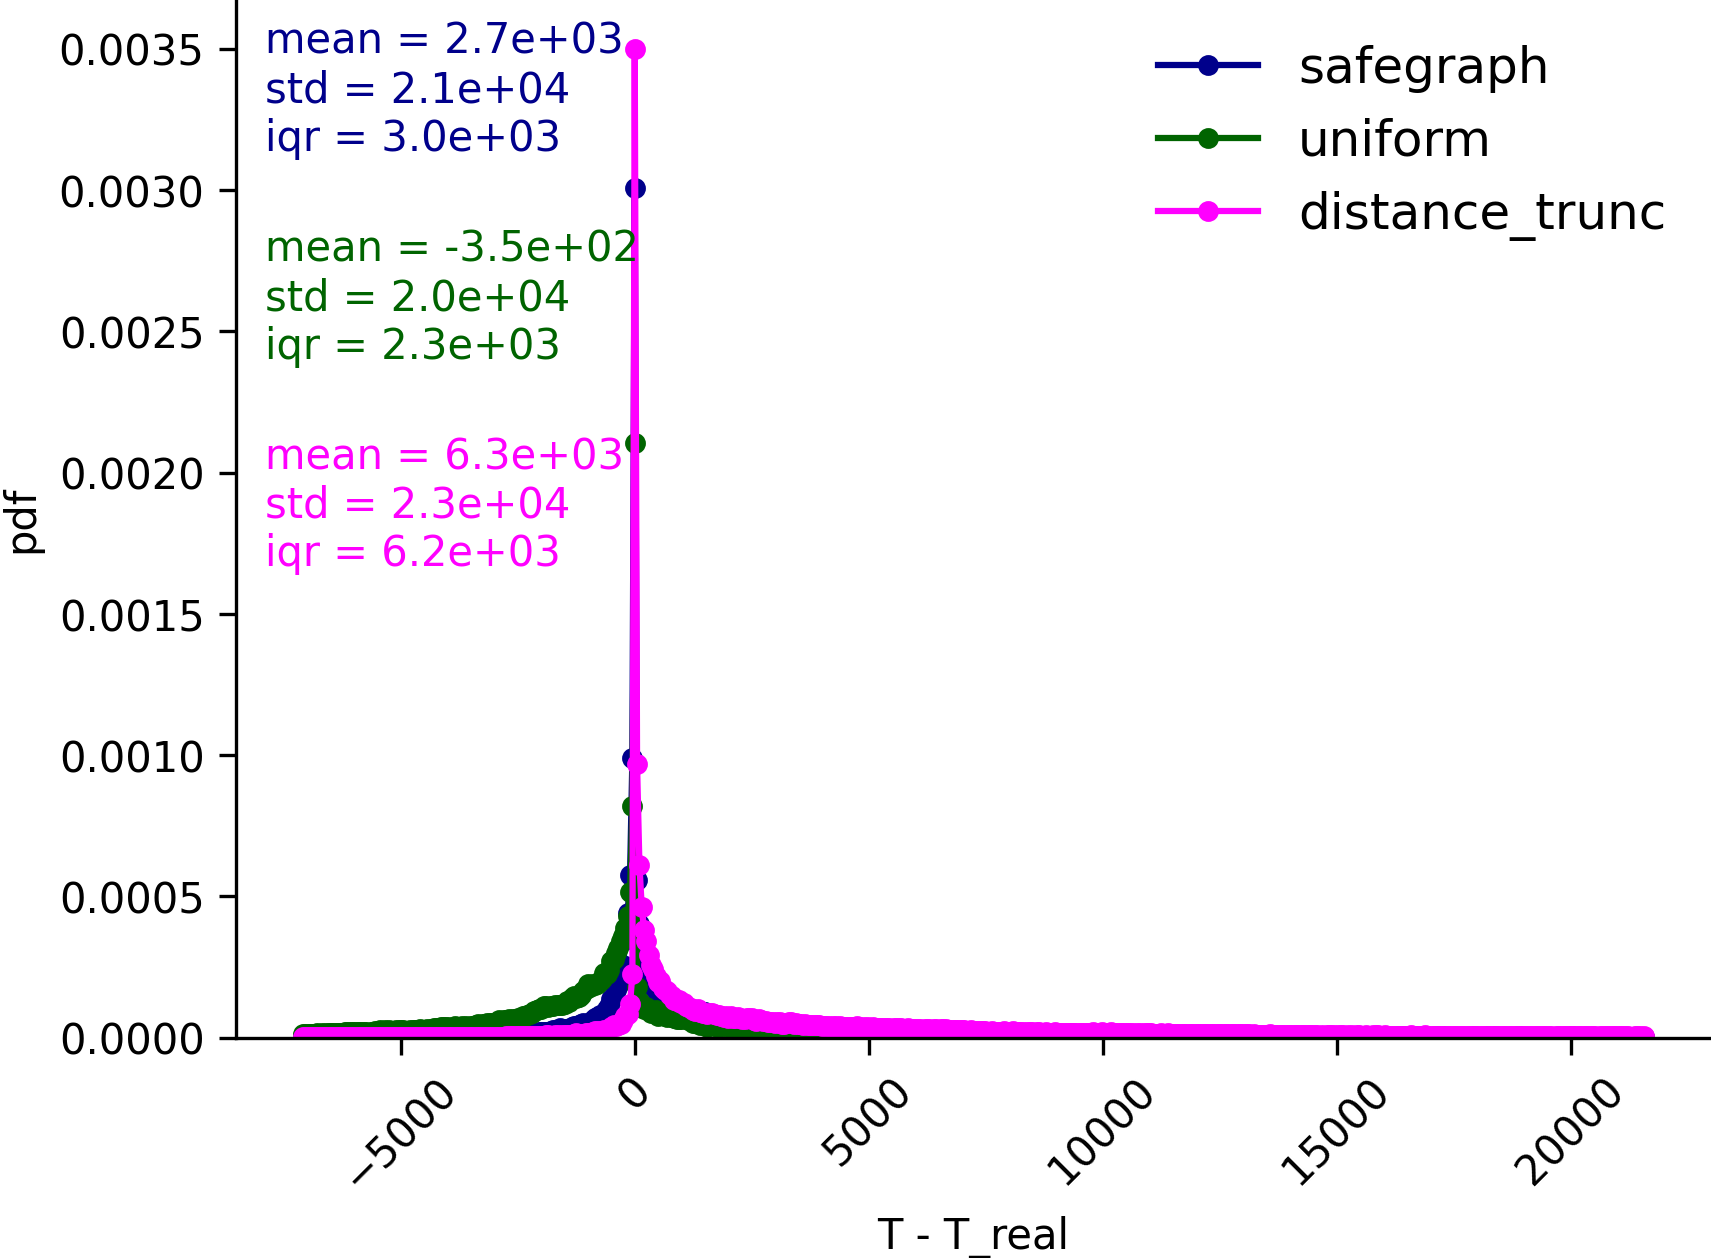

In [42]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

Show profiles

In [43]:
# parameters
fps=10
duration=20
figsize=(6, 4.5)
lw=0.5
ms=4

mydir = figdir / 'profiles_si'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)

styles = ['-']*len(Ss_ramp_list)

Ts = 1.-np.concatenate([Ss_ramp_list, [Ss_real]], axis=0)
dTs = np.concatenate([dTs_ramp_list, [dTs_real]], axis=0)

fpath = mydir / 'profile_T.mp4'
ylabel="$T_a$"
plot_omega_profile(np.einsum('nta,a->nta', Ts, population), times, labels=labels + ['real'], colors=colors + ['red'], \
                   fileout=fpath, tpdir=mydir / 'snapshots_T', dpi=dpi, fps=fps, duration=duration, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=styles + ['o'], deletetp=False, exts=['.png','.svg'], ymin=1.)

fpath = mydir / 'profile_dT.mp4'
ylabel="$dT_a$"
plot_omega_profile(np.einsum('nta,a->nta', dTs, population), times, labels=labels + ['real'], colors=colors + ['red'], \
                   fileout=fpath, tpdir=mydir / 'snapshots_dT', dpi=dpi, fps=fps, duration=duration, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=styles + ['o'], deletetp=False, exts=['.png','.svg'], ymin=1.)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1585, 1214) to (1600, 1216) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/6-LSQ_fit_scales_simplified/profiles_si/profile_T.mp4.


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1587, 1214) to (1600, 1216) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/6-LSQ_fit_scales_simplified/profiles_si/profile_dT.mp4.


In [44]:
fpath = figdir / 'profiles_si' / 'profile_T.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

In [45]:
fpath = figdir / 'profiles_si' / 'profile_dT.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

Show time-dependent map

In [46]:
# parameters
fps=10
duration=20
figsize=(6, 4.5)
lw=0.5
ms=4
idump=1
vmin=1.

Ts = 1. - np.concatenate([Ss_ramp_list, [Ss_real]], axis=0)
dTs = np.concatenate([dTs_ramp_list, [dTs_real]], axis=0)

mydir = figdir / 'maps_si'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)
    
# for i in range(len(Ts)):
for i in range(2):
    label = labels[i]
    fpath = mydir / 'map_T_{:s}.mp4'.format(label)
    plot_omega_map(np.einsum('ta,a->ta', Ts[i], population), times, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
    fileout=fpath, tpdir=mydir / 'snapshots_T_{:s}'.format(label), dpi=dpi, duration=duration, fps=fps, figsize=figsize, \
                   clabel="$T$", deletetp=False, exts=['.png', '.svg'], \
                  vmin=1., vmax=1.0e6)

    fpath = mydir / 'map_dT_{:s}.mp4'.format(label)
    plot_omega_map(np.einsum('ta,a->ta', dTs[i], population), times, XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
    fileout=fpath, tpdir=mydir / 'snapshots_dT_{:s}'.format(label), dpi=dpi, fps=fps, duration=duration, figsize=figsize, \
                   clabel="$dT$", deletetp=False, exts=['.png', '.svg'], \
                  vmin=1., vmax=1.0e4)
print("Written {:s}".format(str(fpath)))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1735, 987) to (1744, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/6-LSQ_fit_scales_simplified/maps_si/map_T_safegraph.mp4.


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1735, 987) to (1744, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/6-LSQ_fit_scales_simplified/maps_si/map_dT_safegraph.mp4.


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1735, 987) to (1744, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/6-LSQ_fit_scales_simplified/maps_si/map_T_uniform.mp4.


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1735, 987) to (1744, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/6-LSQ_fit_scales_simplified/maps_si/map_dT_uniform.mp4.
Written ../figures/6-LSQ_fit_scales_simplified/maps_si/map_dT_uniform.mp4


In [47]:
fpath = figdir / 'maps_si' / 'map_T_safegraph.mp4'
HTML("""
<video height="360" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fpath)))

## Integrate the dynamics based on the nu variables

### SG matrix

In [48]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'scales' / 'nufit_safegraph' / 'infectivity_matrices'
    mykey = str(path / times[0].strftime(tfmt))
    L_sg = store[mykey].to_numpy().astype('float64')
    
    path = Path('/fit') / 'scales' / 'nufit_safegraph' / 'result'
    mykey = str(path / 'susceptible')
    Ss_nufit_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_nufit_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_nufit_sg = store[mykey].to_numpy().astype('float64').ravel()

In [49]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:    
    path = Path('/fit') / 'scales' / 'nuramp_safegraph' / 'result'
    mykey = str(path / 'susceptible')
    Ss_nuramp_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_nuramp_sg = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_nuramp_sg = store[mykey].to_numpy().astype('float64')

dTs_nuramp_sg, dT_tot_nuramp_sg = get_dTs(Ss_nuramp_sg, population)

In [50]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_nuramp_sg, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_nuramp_sg'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_nuramp_sg.png
Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_nuramp_sg.svg


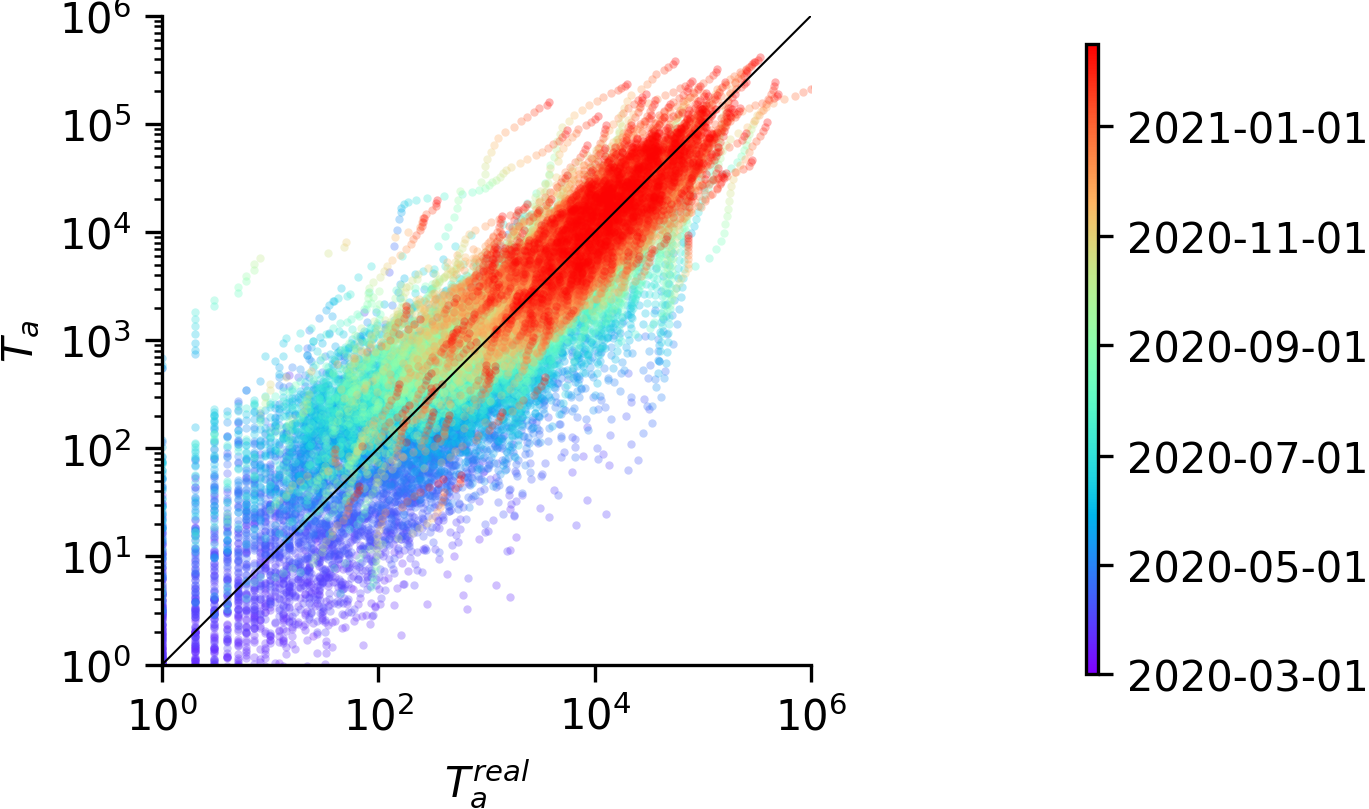

In [51]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [52]:
Xs = Vs_real
Ys = Vs_nuramp_sg
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_nuramp_sg'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_nuramp_sg.png
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_nuramp_sg.svg


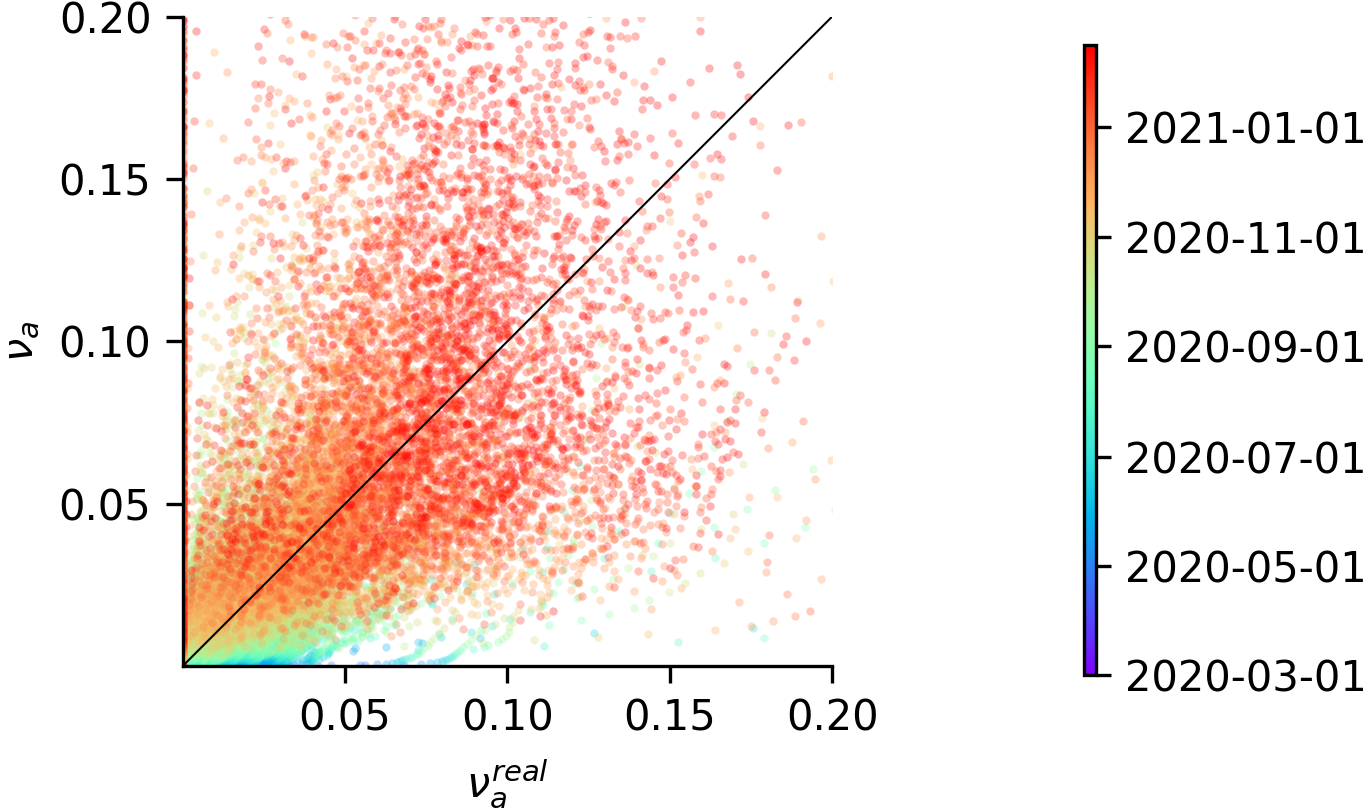

In [53]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Uniform matrix

In [54]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'scales' / 'nufit_uniform' / 'infectivity_matrices'
    mykey = str(path / times[0].strftime(tfmt))
    L_unif = store[mykey].to_numpy().astype('float64')
    
    path = Path('/fit') / 'scales' / 'nufit_uniform' / 'result'
    mykey = str(path / 'susceptible')
    Ss_nufit_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_nufit_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_nufit_unif = store[mykey].to_numpy().astype('float64').ravel()

In [55]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:    
    path = Path('/fit') / 'scales' / 'nuramp_uniform' / 'result'
    mykey = str(path / 'susceptible')
    Ss_nuramp_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_nuramp_unif = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_nuramp_unif = store[mykey].to_numpy().astype('float64')

dTs_nuramp_unif, dT_tot_nuramp_unif = get_dTs(Ss_nuramp_unif, population)

In [56]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_nuramp_unif, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_nuramp_unif'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_nuramp_unif.png
Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_nuramp_unif.svg


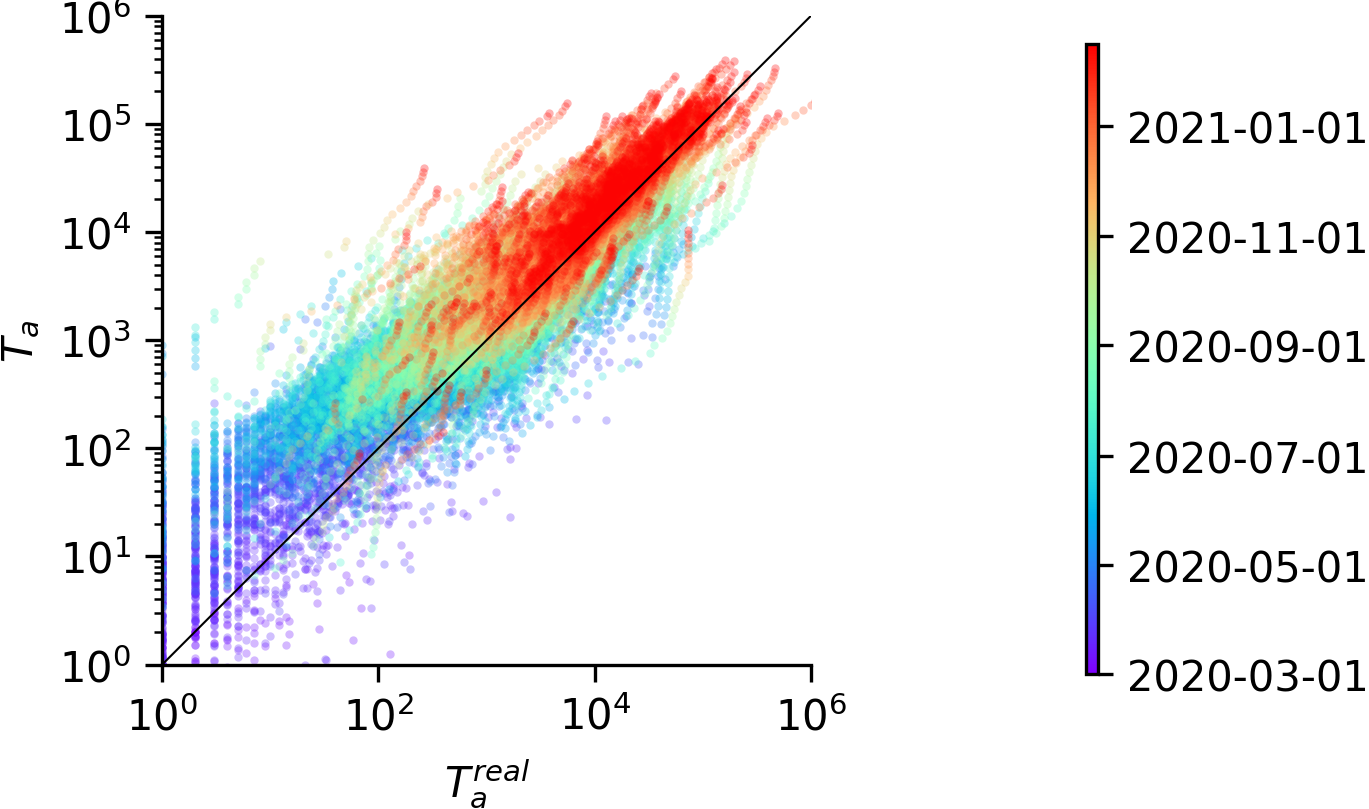

In [57]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [58]:
Xs = Vs_real
Ys = Vs_nuramp_unif
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_nuramp_unif'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_nuramp_unif.png
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_nuramp_unif.svg


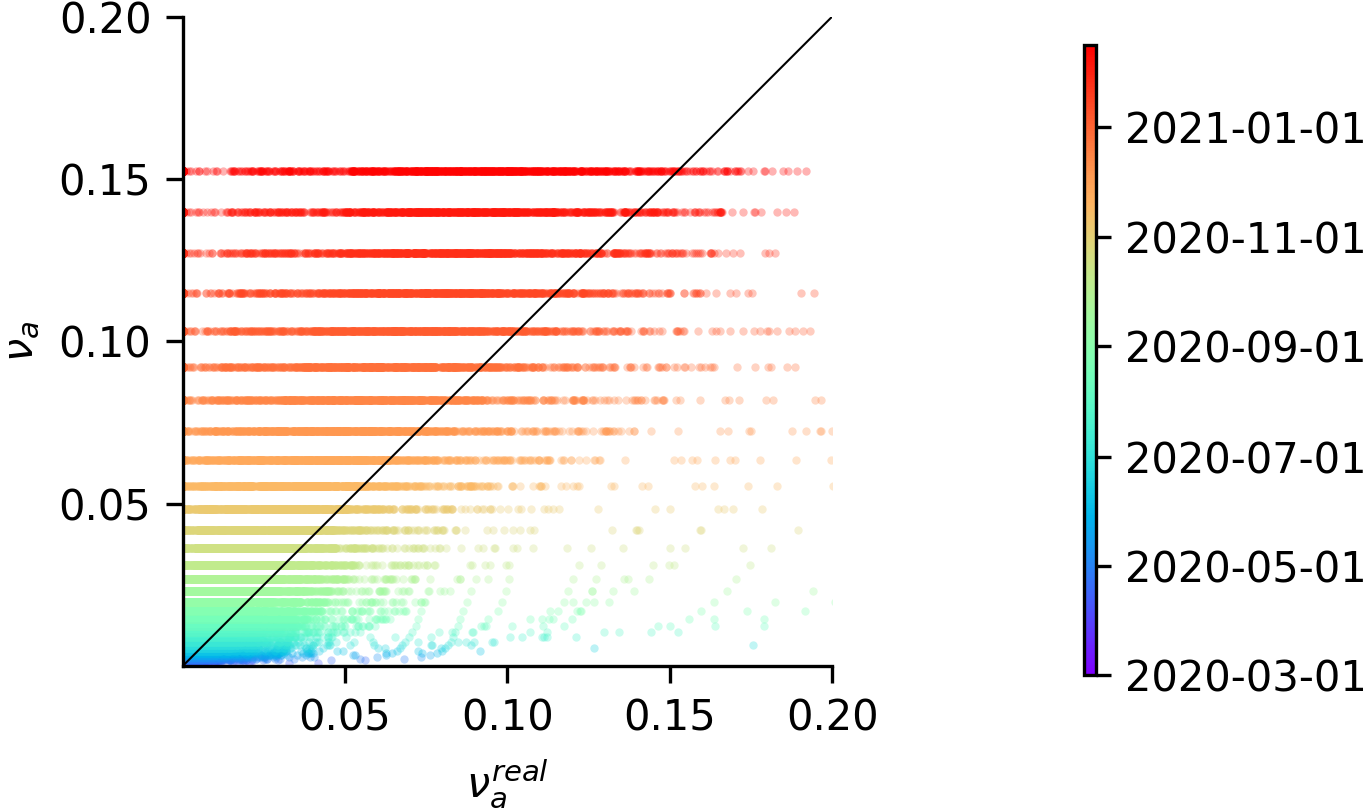

In [59]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### SG matrix

In [60]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    path = Path('/fit') / 'scales' / 'nufit_distance_trunc_400km' / 'infectivity_matrices'
    mykey = str(path / times[0].strftime(tfmt))
    L_trunc = store[mykey].to_numpy().astype('float64')
    
    path = Path('/fit') / 'scales' / 'nufit_distance_trunc_400km' / 'result'
    mykey = str(path / 'susceptible')
    Ss_nufit_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_nufit_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_nufit_trunc = store[mykey].to_numpy().astype('float64').ravel()

In [61]:
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:    
    path = Path('/fit') / 'scales' / 'nuramp_distance_trunc' / 'result'
    mykey = str(path / 'susceptible')
    Ss_nuramp_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'nu')
    Vs_nuramp_trunc = store[mykey].to_numpy().astype('float64')
    
    mykey = str(path / 'scales')
    scales_nuramp_trunc = store[mykey].to_numpy().astype('float64')

dTs_nuramp_trunc, dT_tot_nuramp_trunc = get_dTs(Ss_nuramp_trunc, population)

In [62]:
Xs = np.einsum('ta,a->ta', 1-Ss_real, population)
Ys = np.einsum('ta,a->ta', 1-Ss_nuramp_trunc, population)
idump = 10
vmin = 1.0e0
vmax = 1.0e6
xlabel = "$T_a^{real}$"
ylabel = "$T_a$"
fname = 'T_model_vs_real_nuramp_trunc'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=True, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_nuramp_trunc.png
Written file: ../figures/6-LSQ_fit_scales_simplified/T_model_vs_real_nuramp_trunc.svg


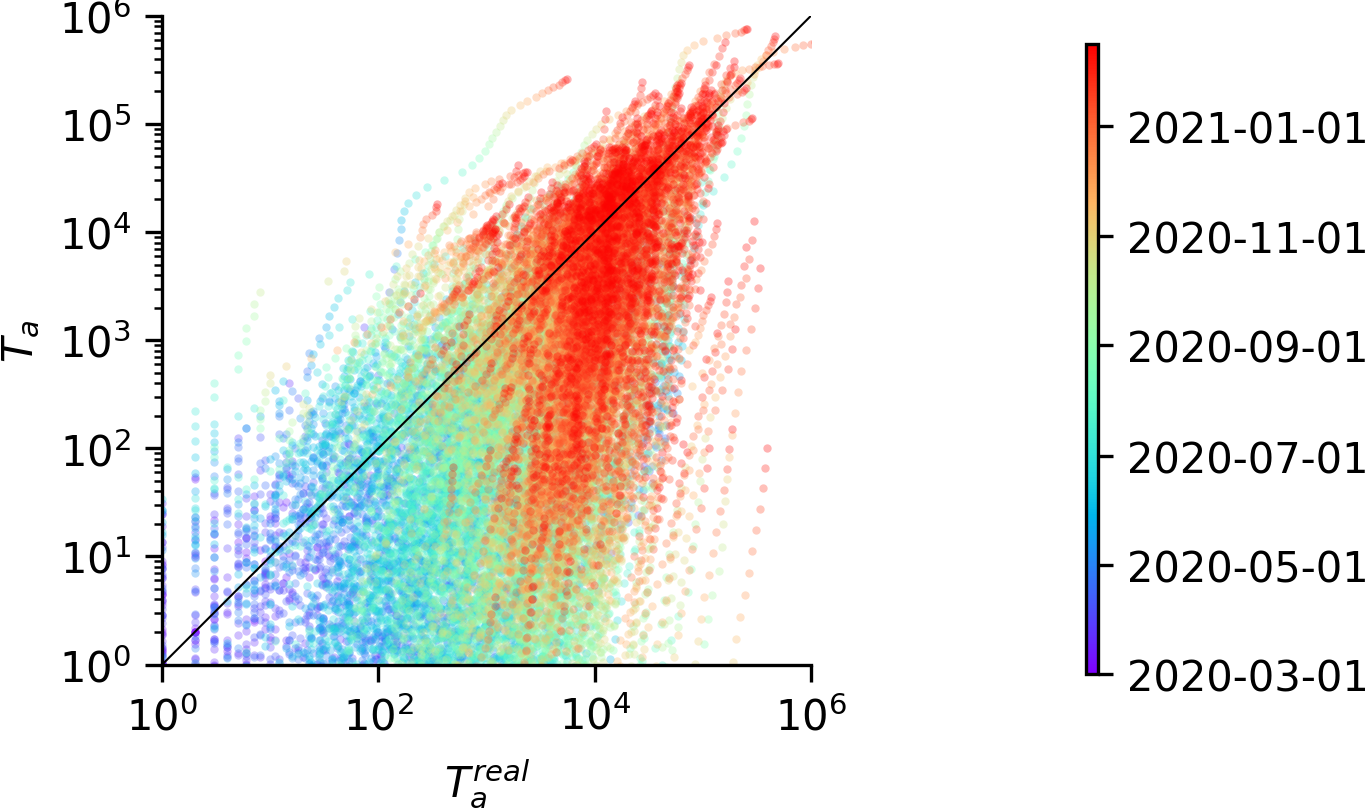

In [63]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [64]:
Xs = Vs_real
Ys = Vs_nuramp_trunc
idump = 10
vmin = 1.0e-5
vmax = 2.0e-1
xlabel = "$\\nu_a^{real}$"
ylabel = "$\\nu_a$"
fname = 'nu_model_vs_real_nuramp_trunc'
fpaths = [figdir / (fname + ext) for ext in exts]

plot_scatter(times, Xs, Ys, idump=idump, vmin=vmin,vmax=vmax, \
                 xlabel=xlabel, ylabel=ylabel, logscale=False, fpaths=fpaths)

Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_nuramp_trunc.png
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_model_vs_real_nuramp_trunc.svg


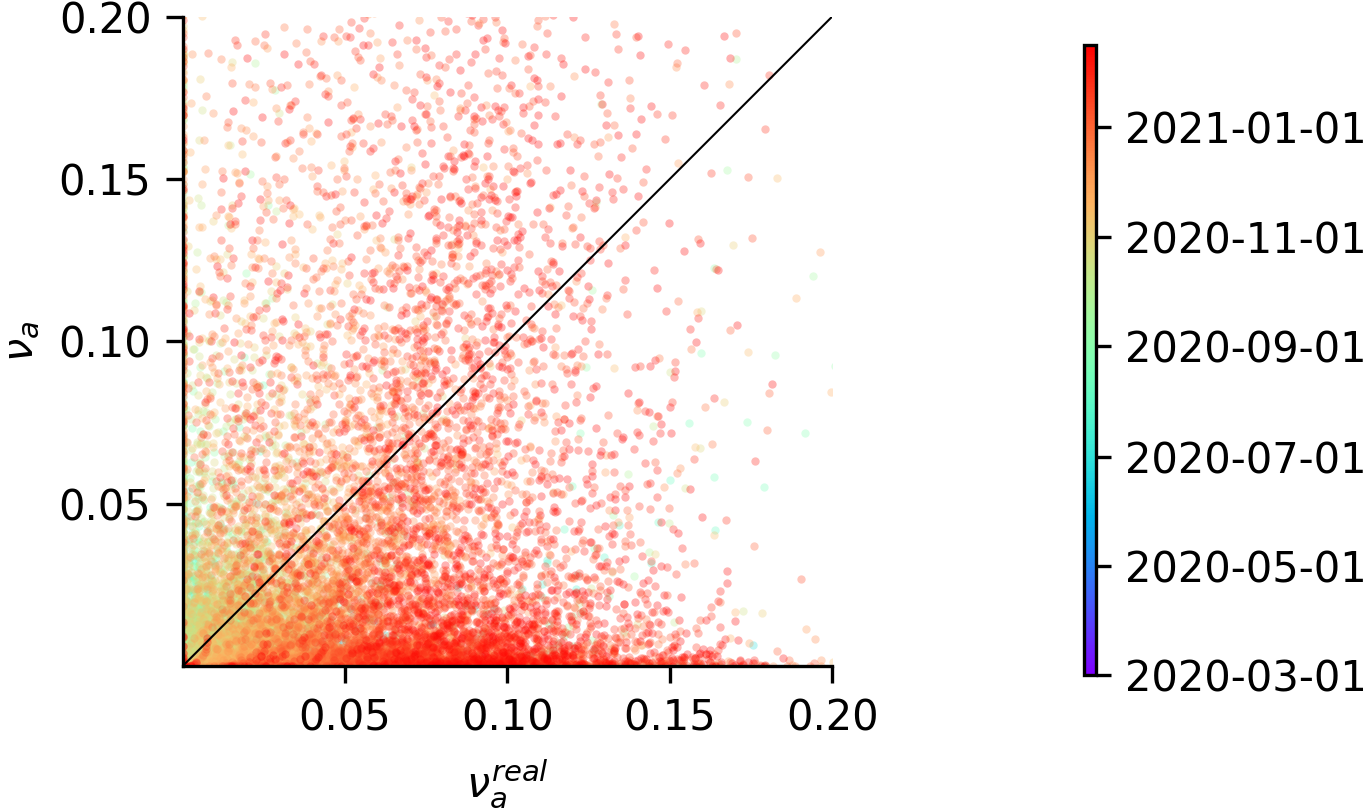

In [65]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Additional analysis and plots

In [66]:
Ss_fit_list = np.array([Ss_nufit_sg, Ss_nufit_unif, Ss_nufit_trunc])
Ss_ramp_list = np.array([Ss_nuramp_sg, Ss_nuramp_unif, Ss_nuramp_trunc])
dTs_ramp_list = np.array([dTs_nuramp_sg, dTs_nuramp_unif, dTs_nuramp_trunc])
T_tot_ramp_list = np.einsum('ita,a->it', 1.-Ss_ramp_list, population)
Vs_ramp_list = np.array([Vs_nuramp_sg, Vs_nuramp_unif, Vs_nuramp_trunc])
dT_tot_ramp_list = np.array([dT_tot_nuramp_sg, dT_tot_nuramp_unif, dT_tot_nuramp_trunc])
scales_fit_list = np.array([scales_nufit_sg, scales_nufit_unif, scales_nufit_trunc])
scales_ramp_list = np.array([scales_nuramp_sg, scales_nuramp_unif, scales_nuramp_trunc])

In [67]:
# parameters
figsize = (4,3)
dpi = 300
ms=3
lw=0.5

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

for i in range(len(scales_fit_list)):
    ax.plot(times[:-1], scales_fit_list[i]/np.mean(scales_ramp_list[i,-1]), 'o', color=colors[i], mfc='none', ms=ms, mew=lw, label=labels[i])
    ax.plot(times[:-1], scales_ramp_list[i]/np.mean(scales_ramp_list[i,-1]), '-', color=colors[i], lw=lw)

ax.legend(loc='best', fontsize='medium', frameon=False)
ax.set_xlim(times[0],None)
ax.set_ylim(0,8)
# ax.set_xlabel("date", fontsize="medium")
ax.set_ylabel("$p \\beta$", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'scales_nu'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')
# plt.show()

Written file: ../figures/6-LSQ_fit_scales_simplified/scales_nu.png
Written file: ../figures/6-LSQ_fit_scales_simplified/scales_nu.svg


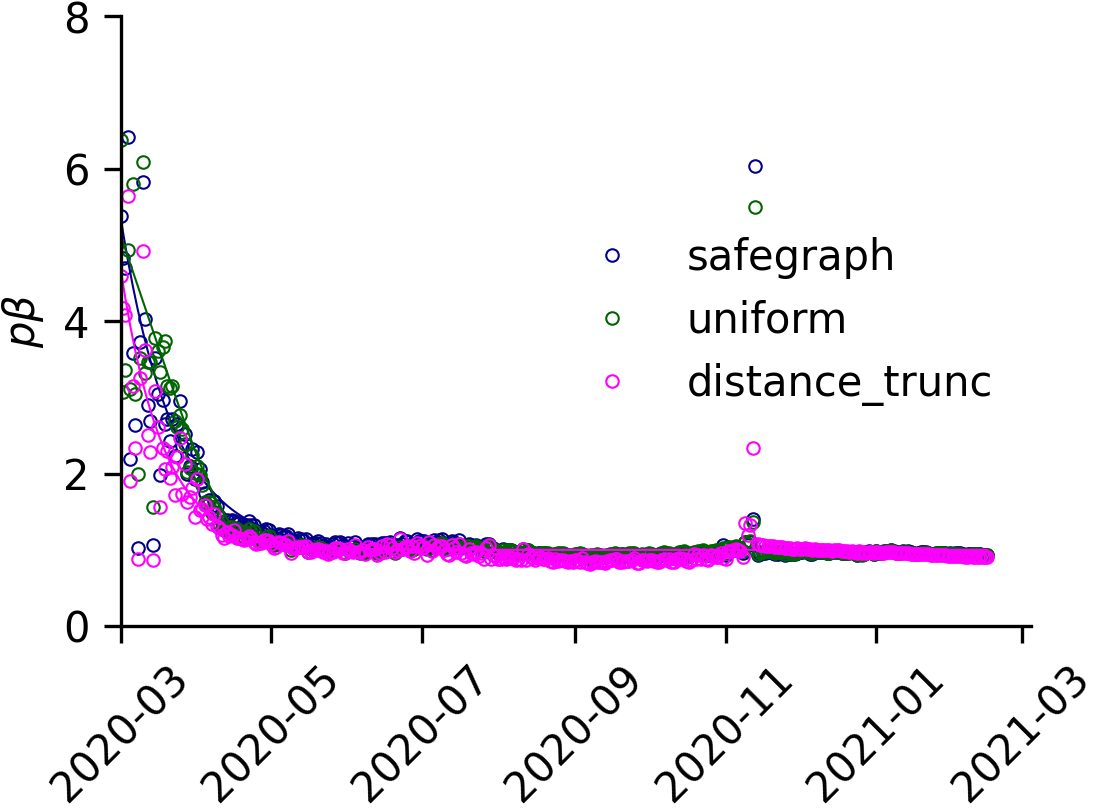

In [68]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [69]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=6
lw=1
show_dT=True
n0=None
ptot = np.sum(population) / 1.0e3


fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

if show_dT:
    for i in range(len(dT_tot_ramp_list)):
        ax.plot(times[:n0],dT_tot_ramp_list[i, :n0]*ptot, '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])
    ax.plot(times[:n0],dT_tot_real[:n0]*ptot, 'o', ms=ms, color='red', mfc='none', mew=lw)
    ax.set_ylabel("$d T$ [x1e3]", fontsize="medium")
    fname = 'dT_tot_ramp_nu'
else:
    for i in range(len(dT_tot_ramp_list)):
        ax.plot(times[:n0],T_tot_ramp_list[i, :n0]*ptot, '-', ms=ms, lw=lw, color=colors[i], mfc='none', mew=lw, label=labels[i])
    ax.plot(times[:n0],T_tot_real[:n0]*ptot, '-', lw=lw, color='red')
    ax.set_ylabel("$T$ [x1e3]", fontsize="medium")
    ax.set_yscale('log')
    fname = 'T_tot_ramp_nu'


ax.legend(loc='best', fontsize='medium', frameon=False)
ax.set_xlim(times[0],None)
ax.set_ylim(0,None)
# ax.set_ylim(0., 300)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/6-LSQ_fit_scales_simplified/dT_tot_ramp_nu.png
Written file: ../figures/6-LSQ_fit_scales_simplified/dT_tot_ramp_nu.svg


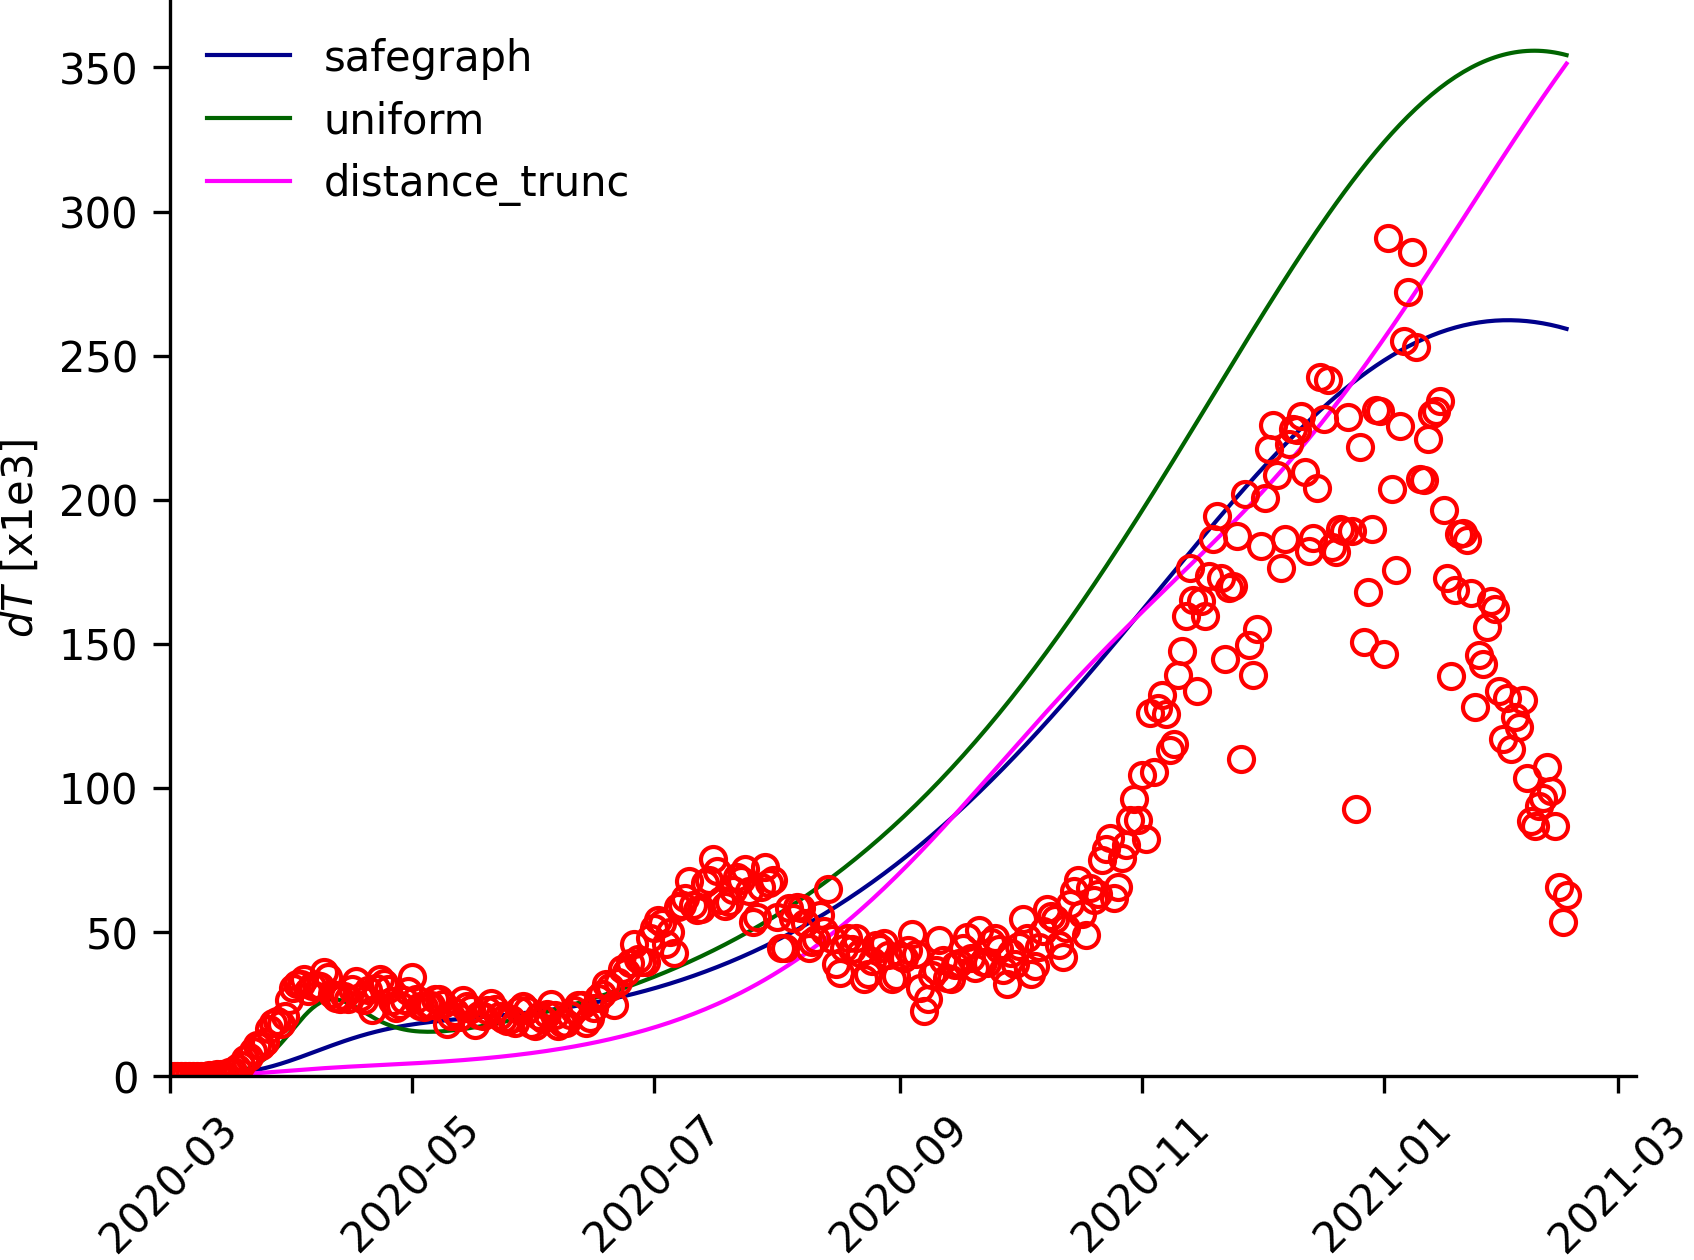

In [70]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

In [71]:
# parameters
figsize = (6,4.5)
dpi = 300
lw=1
ms=4
# bins='doane'
bins='auto'
# bins=2**8
a=10

data = np.array([(Vs - Vs_real).ravel() for Vs in Vs_ramp_list])

q1,q2 = np.percentile(data, [a*0.5, 100-a*0.5])
print(q1, q2)
hist, edges = np.histogram(data[~((data < q1) | (data > q2))], bins=bins, density=True)
print("nbins = {}    bwidth = {}    a = {}    b = {}".format(len(edges)-1, edges[1]-edges[0], edges[0], edges[-1]))

hists = []
for dat in data:
    hist, edges = np.histogram(dat, bins=edges, density=True)
    hists.append(hist)

mus = np.mean(data, axis=1)
stds = np.std(data, axis=1)
iqrs = sst.iqr(data, axis=1)

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

X = 0.5*(edges[:-1] + edges[1:])

for i in range(len(data)):
    hist = hists[i]
    ax.plot(X, hist, 'o-', ms=ms, color=colors[i], label=labels[i])
    ax.annotate("mean = {:.1e}\nstd = {:.1e}\niqr = {:.1e}".format(mus[i], stds[i], iqrs[i]), xy=(0.02, 0.98-i*0.2), \
            xycoords="axes fraction", ha="left", va="top", fontsize="medium", color=colors[i])
    
ax.set_xlabel("nu - nu_real", fontsize="medium")
ax.set_ylabel("pdf", fontsize="medium")

ax.legend(loc='upper right', fontsize='large', frameon=False)
ax.set_ylim(0.,None)
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()
# plt.show()

fname = "nu_errors_nu"
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

-0.053182599526717875 0.06448683630606744
nbins = 571    bwidth = 0.00020607390854298496    a = -0.05318210851195729    b = 0.06448609326608595
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_errors_nu.png
Written file: ../figures/6-LSQ_fit_scales_simplified/nu_errors_nu.svg


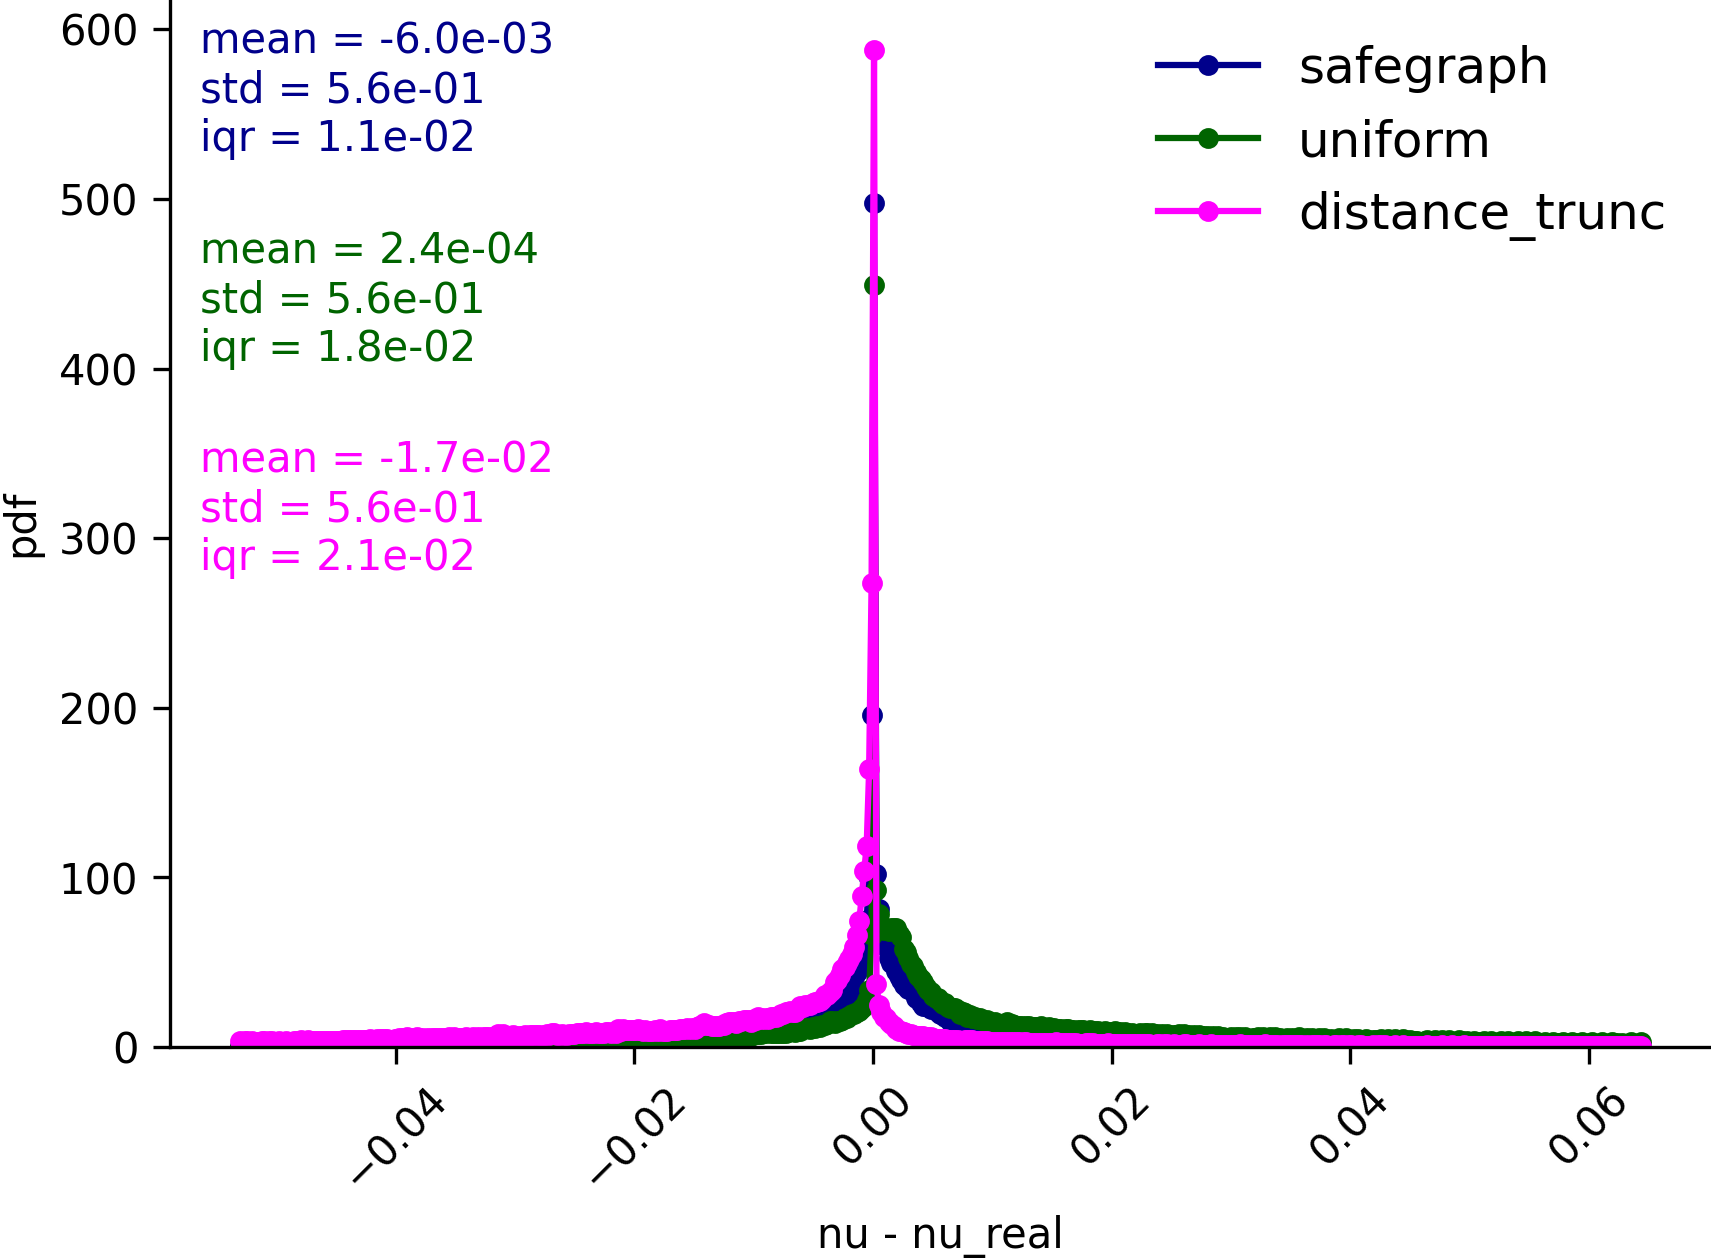

In [72]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)